# <font color=green>Custom CNN Model for Early Detection of Alzheimer’s Diseases in MRI Scans</font>

### <font color=cyan> Group 34, Evan Chen & Aaron Almeida </font>
### <font color=cyan> Final Code Submission </font>

### **<font color=purple> packages that need to be install to run this code </font>**



In [ ]:
!pip install imblearn
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install kagglehub
!pip install torch
!pip install torchsummary
!pip install grad-cam
!pip install scikit-image

### <font color=orange> Importing Libraries </font>

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


### <font color=orange> Checks to ensure GPU is being utilized </font>

In [3]:
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version (PyTorch):", torch.version.cuda)


CUDA Available: True
CUDA Version (PyTorch): 11.8


In [4]:
print("cuDNN Version:", torch.backends.cudnn.version())


cuDNN Version: 90100


In [5]:
print("Device Name:", torch.cuda.get_device_name(0))
print("Device Capability:", torch.cuda.get_device_capability(0))


Device Name: NVIDIA GeForce RTX 3070
Device Capability: (8, 6)


### <font color=orange> Load in dataset </font>

In [2]:
import kagglehub

# Download the dataset
import kagglehub

# Download dataset and capture path
dataset_path = kagglehub.dataset_download("abdullahtauseef2003/adni-4c-alzheimers-mri-classification-dataset")
print("Dataset path:", dataset_path)


import os
print(os.listdir(dataset_path))


d:\Anaconda\envs\test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset path: C:\Users\aaron\.cache\kagglehub\datasets\abdullahtauseef2003\adni-4c-alzheimers-mri-classification-dataset\versions\1
['AugmentedAlzheimerDataset']


### <font color=orange> Image transformation and Train/Validation/Test Split </font>

In [ ]:
# Image Transformations to 128x128 to retain image quality but downsize for efficient evaluation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the Dataset
data_dir = os.path.join(dataset_path, "AugmentedAlzheimerDataset")
dataset = ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
print("Classes:", class_names)

# Split Sizes
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # to ensure all data is used

# Dataset Splitting (80% train, 10% val, 10% test)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Classes: ['AD', 'CN', 'EMCI', 'LMCI']


### <font color=orange> Model Architecture </font>

In [29]:
print("""
Input: Grayscale MRI Image (1 x 128 x 128)
│
├── Conv2D (1 → 16, kernel_size=3, padding=1)
├── ReLU
├── MaxPool2D (2x2)
│
├── Conv2D (16 → 32, kernel_size=3, padding=1)
├── ReLU
├── MaxPool2D (2x2)
│
├── Conv2D (32 → 64, kernel_size=3, padding=1)
├── ReLU
├── MaxPool2D (2x2)
│
├── Flatten (64x16x16 → 16384)
├── Linear (16384 → 128)
├── ReLU
├── Dropout (p=0.3)
└── Linear (128 → 4)
    → Output: [AD, CN, EMCI, LMCI]
""")



Input: Grayscale MRI Image (1 x 128 x 128)
│
├── Conv2D (1 → 16, kernel_size=3, padding=1)
├── ReLU
├── MaxPool2D (2x2)
│
├── Conv2D (16 → 32, kernel_size=3, padding=1)
├── ReLU
├── MaxPool2D (2x2)
│
├── Conv2D (32 → 64, kernel_size=3, padding=1)
├── ReLU
├── MaxPool2D (2x2)
│
├── Flatten (64x16x16 → 16384)
├── Linear (16384 → 128)
├── ReLU
├── Dropout (p=0.3)
└── Linear (128 → 4)
    → Output: [AD, CN, EMCI, LMCI]



### <font color=orange> Class Balancing </font>

In [6]:

from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import WeightedRandomSampler

# Extract labels from the training dataset
all_labels = [label for _, label in train_dataset]

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Apply to loss function
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Prepare weights for sampling
class_counts = np.bincount(all_labels)
weights = 1. / class_counts
sample_weights = [weights[label] for label in all_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Updated DataLoader using the sampler
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### <font color=orange> Check if images are loaded in</font>

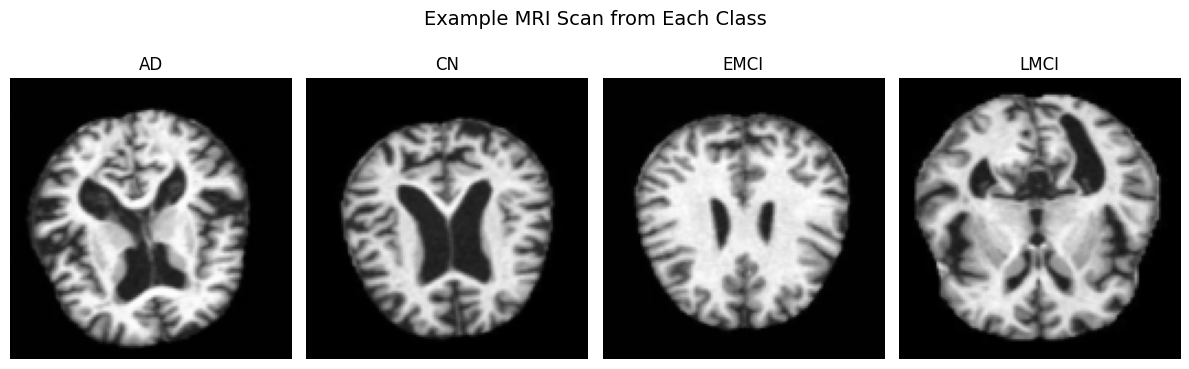

In [7]:
import matplotlib.pyplot as plt

# Map to store first image per class
examples = {}
fig, axes = plt.subplots(1, len(class_names), figsize=(12, 4))

for img, label in val_dataset:
    label = int(label)
    if label not in examples:
        examples[label] = img
    if len(examples) == len(class_names):
        break

# Plot each
for idx, class_id in enumerate(sorted(examples.keys())):
    img_tensor = examples[class_id]
    img = img_tensor.squeeze().numpy()  # remove channel dim if grayscale

    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(class_names[class_id])
    axes[idx].axis('off')

plt.suptitle("Example MRI Scan from Each Class", fontsize=14)
plt.tight_layout()
plt.show()


### <font color=orange> Model Creation </font>

In [8]:
class AlzheimerCNN(nn.Module):
    def __init__(self):
        super(AlzheimerCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = AlzheimerCNN().to(device)
print(model)


AlzheimerCNN(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=16384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=4, bias=True)
  )
)


### <font color=orange> Training & Evaluation </font>

In [9]:
def train(model, loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader):.4f}")


In [10]:
def evaluate(model, loader, class_names):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


Epoch 1/10, Loss: 1.1697
Epoch 2/10, Loss: 0.8902
Epoch 3/10, Loss: 0.7895
Epoch 4/10, Loss: 0.7235
Epoch 5/10, Loss: 0.6833
Epoch 6/10, Loss: 0.6469
Epoch 7/10, Loss: 0.6004
Epoch 8/10, Loss: 0.5757
Epoch 9/10, Loss: 0.5413
Epoch 10/10, Loss: 0.5127
Classification Report:
              precision    recall  f1-score   support

          AD       0.75      0.85      0.80       890
          CN       0.98      0.98      0.98       680
        EMCI       0.78      0.69      0.73       952
        LMCI       0.65      0.64      0.65       876

    accuracy                           0.78      3398
   macro avg       0.79      0.79      0.79      3398
weighted avg       0.78      0.78      0.78      3398



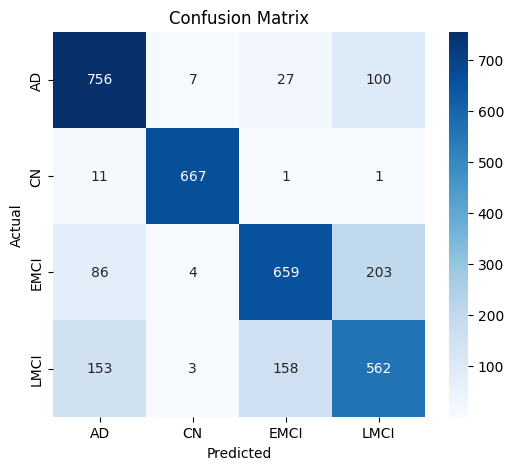

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train(model, train_loader, criterion, optimizer, epochs=10)

#evaluation based on validation set
evaluate(model, val_loader, class_names)


In [16]:
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
import time


Train samples: 27187
Val samples: 3398
Test samples: 3399


Classification Report:
              precision    recall  f1-score   support

          AD       0.76      0.84      0.80       878
          CN       0.98      0.98      0.98       676
        EMCI       0.79      0.66      0.72       973
        LMCI       0.65      0.68      0.67       872

    accuracy                           0.78      3399
   macro avg       0.79      0.79      0.79      3399
weighted avg       0.78      0.78      0.78      3399



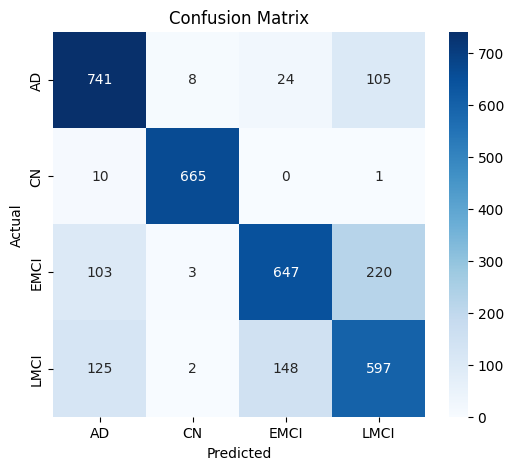

⏱️ Test evaluation took 3.47 seconds


In [ ]:
# Timing test_loader evaluation
t0 = time.time()

#evaluation based on test set
evaluate(model, test_loader, class_names)
t1 = time.time()
print(f"⏱️ Test evaluation took {t1 - t0:.2f} seconds")

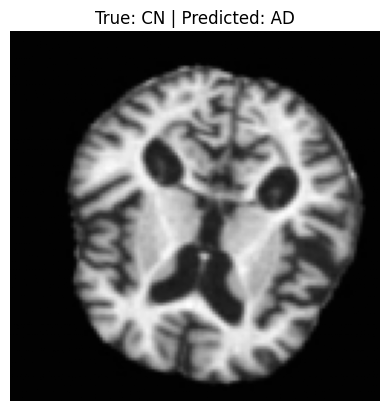

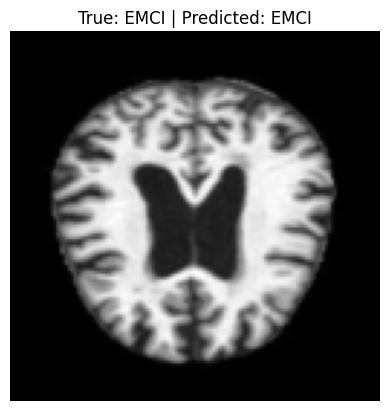

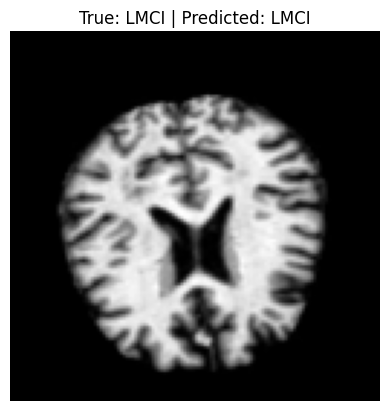

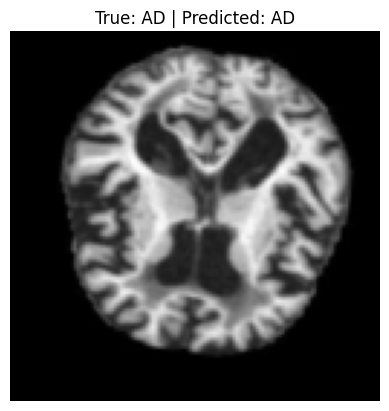

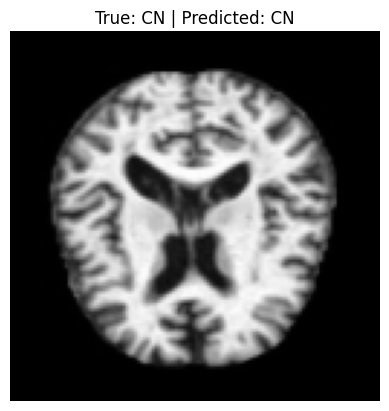

In [18]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Visualize the first 5 images
        for i in range(5):
            img = inputs[i].cpu().squeeze().numpy()
            plt.imshow(img, cmap="gray")
            plt.title(f"True: {class_names[labels[i]]} | Predicted: {class_names[preds[i]]}")
            plt.axis("off")
            plt.show()
        break


### <font color=orange> Grad-CAM Implementation </font>

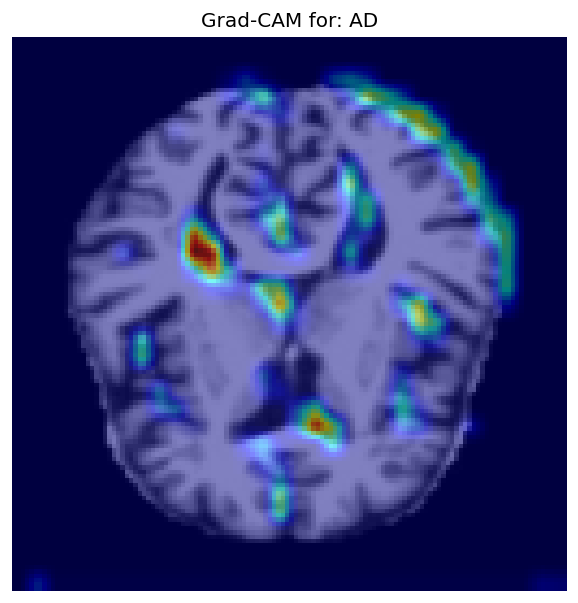

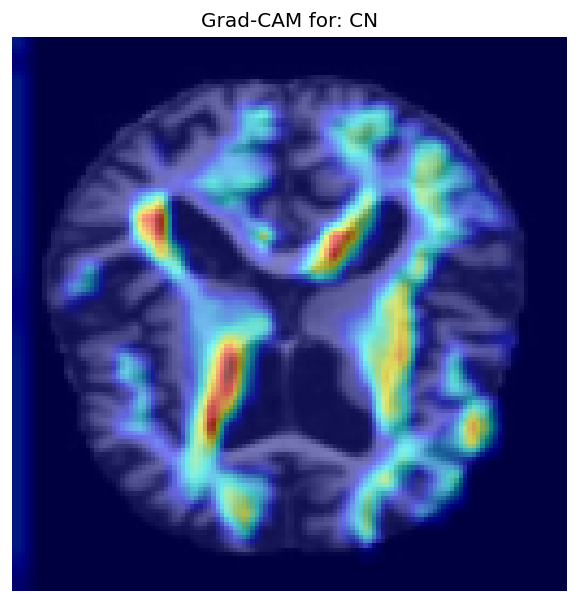

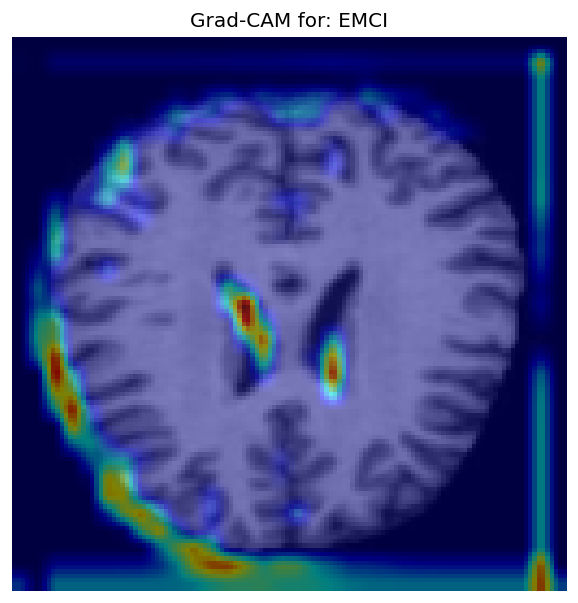

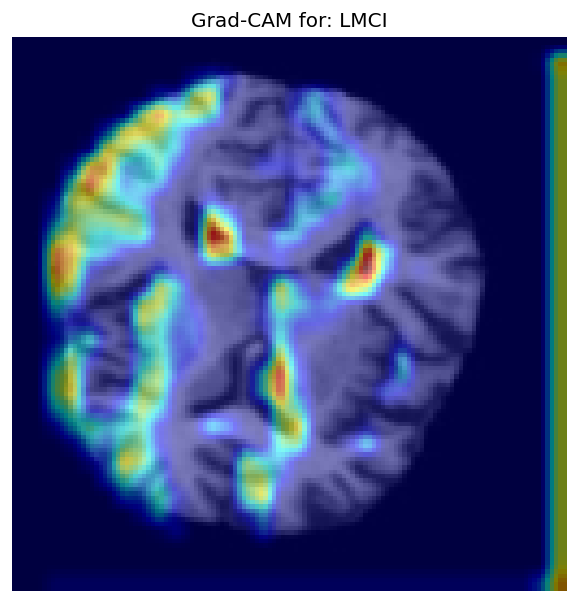

In [28]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from collections import defaultdict

# Reduce figure size a bit
figsize = (6, 6)
dpi = 120

# -----------------------------
# Step 1: Random Sample per Class
# -----------------------------
# Group indices by class
indices_by_class = defaultdict(list)
for idx, (_, label) in enumerate(val_dataset):
    indices_by_class[int(label)].append(idx)

# Choose one random sample per class
samples_by_class = {}
for class_idx in range(len(class_names)):
    chosen_idx = random.choice(indices_by_class[class_idx])
    sample_img, _ = val_dataset[chosen_idx]
    samples_by_class[class_idx] = sample_img

# -----------------------------
# Step 2: Setup GradCAM
# -----------------------------
target_layer = model.conv[-3]  # You can adjust this as needed
cam = GradCAM(model=model, target_layers=[target_layer])

# -----------------------------
# Step 3: Visualize GradCAM
# -----------------------------
for class_idx, sample_img in samples_by_class.items():
    input_tensor = sample_img.unsqueeze(0).to(device)
    targets = [ClassifierOutputTarget(class_idx)]

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Prepare image
    img_rgb = sample_img.permute(1, 2, 0).cpu().numpy()
    img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())
    img_rgb_resized = cv2.resize(img_rgb, (grayscale_cam.shape[1], grayscale_cam.shape[0]))
    img_rgb_uint8 = np.uint8(255 * img_rgb_resized)

    if img_rgb_uint8.ndim == 2 or img_rgb_uint8.shape[2] == 1:
        img_rgb_uint8 = cv2.cvtColor(img_rgb_uint8, cv2.COLOR_GRAY2RGB)

    # Overlay heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(img_rgb_uint8, 0.5, heatmap, 0.5, 0)

    # Show
    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM for: {class_names[class_idx]}")
    plt.axis("off")
    plt.show()
